In [1]:
import tensorflow as tf
import tensorflow.keras.preprocessing.image
import PIL
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from IPython.display import Image, display
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import drive
from google.colab import files



In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures
  # directory with our validation dog pictures

num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

68608000/68606236 [==============================] - 0s 0us/step


In [3]:
batch_size = 128
epochs = 50
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [4]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [5]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [6]:
IMG_SHAPE = (160, 160, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [7]:
for image_batch, label_batch in train_data_gen:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (128, 150, 150, 3)
Label batch shape:  (128,)


In [8]:
base_model.trainable = False

In [14]:
image_batch, label_batch = next(iter(train_data_gen))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(128, 4, 4, 1280)


In [9]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [15]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(128, 1280)


In [16]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(128, 1)


In [17]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [18]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [26]:
initial_epochs = 30
validation_steps=20

loss0,accuracy0 = model.evaluate(val_data_gen, steps = validation_steps)

 8/20 [===========>..................] - 3s 319ms/step - loss: 0.1914 - accuracy: 0.9300


In [27]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.19
initial accuracy: 0.93


In [28]:
history = model.fit(train_data_gen,
                    epochs=initial_epochs,
                    validation_data=val_data_gen)

Epoch 1/30
16/16 [==============================] - 9s 544ms/step - loss: 0.1826 - accuracy: 0.9405 - val_loss: 0.1757 - val_accuracy: 0.9340
Epoch 2/30
16/16 [==============================] - 8s 525ms/step - loss: 0.1687 - accuracy: 0.9450 - val_loss: 0.1637 - val_accuracy: 0.9390
Epoch 3/30
16/16 [==============================] - 8s 522ms/step - loss: 0.1571 - accuracy: 0.9445 - val_loss: 0.1544 - val_accuracy: 0.9410
Epoch 4/30
16/16 [==============================] - 8s 523ms/step - loss: 0.1479 - accuracy: 0.9505 - val_loss: 0.1453 - val_accuracy: 0.9510
Epoch 5/30
16/16 [==============================] - 8s 524ms/step - loss: 0.1393 - accuracy: 0.9505 - val_loss: 0.1385 - val_accuracy: 0.9550
Epoch 6/30
16/16 [==============================] - 8s 522ms/step - loss: 0.1327 - accuracy: 0.9535 - val_loss: 0.1332 - val_accuracy: 0.9550
Epoch 7/30
16/16 [==============================] - 8s 525ms/step - loss: 0.1269 - accuracy: 0.9530 - val_loss: 0.1284 - val_accuracy: 0.9590
Epoch 

In [29]:
drive.mount('/content/drive')
path = path = F"/content/drive/My Drive/catsvsdogsmodelsave" 
model.save(path)

Mounted at /content/drive
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/catsvsdogsmodelsave/assets


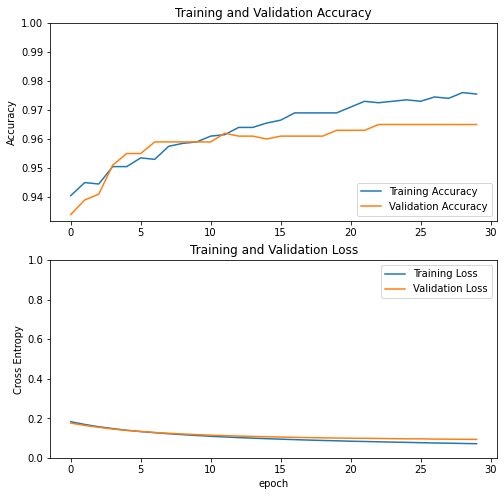

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Saving 220px-Felis_catus-cat_on_snow.jpg to 220px-Felis_catus-cat_on_snow.jpg


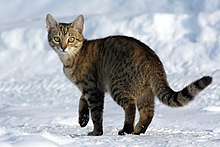

In [ ]:
#upload a file to colab to make some predictions with the model
uploaded = files.upload()
for fn in uploaded.keys():
  display(Image(fn))
  

In [ ]:
#prediction function
def makepredictions(filename):
  img = load_img(filename)
  img = img.resize((160, 160), resample=PIL.Image.BICUBIC)
  arr = img_to_array(img)
  arr = np.expand_dims(arr, axis=0)
  arr /= 255
  prediction = (model.predict(arr) > 0.5).astype("int32")
  y = prediction[0]
  return (('This is likely a Dog' if y >0 else 'This is likely a Cat')) 

In [ ]:
#make the prediction
for fn in uploaded.keys():
  print(makepredictions(fn))

This is likely a Cat
